In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from tqdm import tqdm, trange
import pickle

from sklearn.preprocessing import LabelEncoder

In [2]:
test = pd.read_csv('data/test.csv', engine='pyarrow')
test_zero_indices = test.DIST==0

with open('data/test_zero_indices', 'wb') as f:
    pickle.dump(test_zero_indices, f)

In [3]:
train = pd.read_csv('data/train.csv', engine='pyarrow')
train = train.loc[train.DIST!=0, :]
train.drop(columns=['SAMPLE_ID', 'ID'], inplace=True)
train = train.sort_values(by=['ARI_CO', 'ARI_PO', 'ATA'], ascending=True)
train = train.reset_index(drop=True)
train.columns = train.columns.str.lower()

test = pd.read_csv('data/test.csv', engine='pyarrow')
test = test.loc[test.DIST!=0, :]
test.drop(columns=['SAMPLE_ID', 'ID'], inplace=True)
test = test.reset_index(drop=True)
test.columns = test.columns.str.lower()

train.head()

,ari_co,ari_po,ship_type_category,dist,ata,breadth,built,deadweight,depth,draught,...,length,shipmanager,flag,u_wind,v_wind,air_temperature,bn,ata_lt,port_size,ci_hour
0,AU,AIB7,Bulk,32.590869,2014-09-01 10:42,40.0,28,170000,20.0,20.0,...,290.0,LCQE13,Panama,NaN,NaN,NaN,NaN,21,0.000113,161.218056
1,AU,AIB7,Bulk,35.575496,2014-09-01 1:03,30.0,20,53000,20.0,10.0,...,190.0,QSHW38,Panama,NaN,NaN,NaN,NaN,11,0.000113,95.767500
2,AU,AIB7,Bulk,40.909139,2014-09-01 1:08,40.0,13,88100,20.0,10.0,...,230.0,YQFC33,Japan,NaN,NaN,NaN,NaN,11,0.000113,35.445556
3,AU,AIB7,Bulk,45.939559,2014-09-01 1:15,40.0,11,107000,20.0,10.0,...,250.0,DRPR74,"Hong Kong, China",NaN,NaN,NaN,NaN,11,0.000113,95.507222
4,AU,AIB7,Bulk,15.606497,2014-09-01 1:15,30.0,11,81700,20.0,10.0,...,230.0,LKMN58,India,NaN,NaN,NaN,NaN,11,0.000113,99.873056


In [4]:
train['month'] = pd.to_datetime(train.ata).dt.month
test['month'] = pd.to_datetime(test.ata).dt.month

# Imputation of `U_WIND`, `V_WIND`, `BN`

In [5]:
yan_train = train.loc[train.u_wind.notnull(), :]

nan_train = train.loc[train.u_wind.isnull(), :]
nan_test = test.loc[test.u_wind.isnull(), :]
nan_train.head()

,ari_co,ari_po,ship_type_category,dist,ata,breadth,built,deadweight,depth,draught,...,shipmanager,flag,u_wind,v_wind,air_temperature,bn,ata_lt,port_size,ci_hour,month
0,AU,AIB7,Bulk,32.590869,2014-09-01 10:42,40.0,28,170000,20.0,20.0,...,LCQE13,Panama,NaN,NaN,NaN,NaN,21,0.000113,161.218056,9
1,AU,AIB7,Bulk,35.575496,2014-09-01 1:03,30.0,20,53000,20.0,10.0,...,QSHW38,Panama,NaN,NaN,NaN,NaN,11,0.000113,95.767500,9
2,AU,AIB7,Bulk,40.909139,2014-09-01 1:08,40.0,13,88100,20.0,10.0,...,YQFC33,Japan,NaN,NaN,NaN,NaN,11,0.000113,35.445556,9
3,AU,AIB7,Bulk,45.939559,2014-09-01 1:15,40.0,11,107000,20.0,10.0,...,DRPR74,"Hong Kong, China",NaN,NaN,NaN,NaN,11,0.000113,95.507222,9
4,AU,AIB7,Bulk,15.606497,2014-09-01 1:15,30.0,11,81700,20.0,10.0,...,LKMN58,India,NaN,NaN,NaN,NaN,11,0.000113,99.873056,9


In [6]:
yan_groupby = yan_train.groupby(['ari_co', 'ari_po', 'month'])
yan_u = yan_groupby['u_wind'].mean()
yan_v = yan_groupby['v_wind'].mean()
yan_bn = yan_groupby['bn'].mean()
yan_indices = yan_u.index
nan_train_array = nan_train.values

fill_list = []; fill_append = fill_list.append
for row in trange(nan_train.shape[0]):
    co, po, month = nan_train_array[row, [0, 1, -1]]

    if (co, po, month) in yan_indices:
        u_fill = yan_u[(co, po, month)]
        v_fill = yan_v[(co, po, month)]
        bn_fill = yan_bn[(co, po, month)]
        fill = (u_fill, v_fill, bn_fill)
    else:
        fill = (np.nan, np.nan, np.nan)

    fill_append(fill)

train.loc[train.u_wind.isnull(), ['u_wind', 'v_wind', 'bn']] = fill_list

100%|██████████| 92445/92445 [00:03<00:00, 24005.95it/s]


In [7]:
nan_test_array = nan_test.values

fill_list = []; fill_append = fill_list.append
for row in trange(nan_test.shape[0]):
    co, po, month = nan_test_array[row, [0, 1, -1]]

    if (co, po, month) in yan_indices:
        u_fill = yan_u[(co, po, month)]
        v_fill = yan_v[(co, po, month)]
        bn_fill = yan_bn[(co, po, month)]
        fill = (u_fill, v_fill, bn_fill)
    else:
        fill = (np.nan, np.nan, np.nan)

    fill_append(fill)

test.loc[test.u_wind.isnull(), ['u_wind', 'v_wind', 'bn']] = fill_list

100%|██████████| 51891/51891 [00:02<00:00, 23364.48it/s]


# Imputation of `AIR_TEMPERATURE`
+ `21` `NaN` still remain in train set
+ `14` `NaN` still remain in test set

In [8]:
yan_train = train.loc[train.air_temperature.notnull(), :]

nan_train = train.loc[train.air_temperature.isnull(), :]
nan_test = test.loc[test.air_temperature.isnull(), :]
nan_train.head()

,ari_co,ari_po,ship_type_category,dist,ata,breadth,built,deadweight,depth,draught,...,shipmanager,flag,u_wind,v_wind,air_temperature,bn,ata_lt,port_size,ci_hour,month
0,AU,AIB7,Bulk,32.590869,2014-09-01 10:42,40.0,28,170000,20.0,20.0,...,LCQE13,Panama,-0.363571,-1.574429,NaN,4.061694,21,0.000113,161.218056,9
1,AU,AIB7,Bulk,35.575496,2014-09-01 1:03,30.0,20,53000,20.0,10.0,...,QSHW38,Panama,-0.363571,-1.574429,NaN,4.061694,11,0.000113,95.767500,9
2,AU,AIB7,Bulk,40.909139,2014-09-01 1:08,40.0,13,88100,20.0,10.0,...,YQFC33,Japan,-0.363571,-1.574429,NaN,4.061694,11,0.000113,35.445556,9
3,AU,AIB7,Bulk,45.939559,2014-09-01 1:15,40.0,11,107000,20.0,10.0,...,DRPR74,"Hong Kong, China",-0.363571,-1.574429,NaN,4.061694,11,0.000113,95.507222,9
4,AU,AIB7,Bulk,15.606497,2014-09-01 1:15,30.0,11,81700,20.0,10.0,...,LKMN58,India,-0.363571,-1.574429,NaN,4.061694,11,0.000113,99.873056,9


In [9]:
yan_air = yan_groupby['air_temperature'].mean()
yan_indices = yan_u.index
nan_train_array = nan_train.values

fill_list = []; fill_append = fill_list.append
for row in trange(nan_train.shape[0]):
    co, po, month = nan_train_array[row, [0, 1, -1]]

    if (co, po, month) in yan_indices:
        fill = yan_air[(co, po, month)]
    else:
        fill = np.nan

    fill_append(fill)

train.loc[train.air_temperature.isnull(), 'air_temperature'] = fill_list

100%|██████████| 93041/93041 [00:02<00:00, 44555.20it/s]


In [10]:
yan_air = yan_groupby['air_temperature'].mean()
yan_indices = yan_u.index
nan_test_array = nan_test.values

fill_list = []; fill_append = fill_list.append
for row in trange(nan_test.shape[0]):
    co, po, month = nan_test_array[row, [0, 1, -1]]

    if (co, po, month) in yan_indices:
        fill = yan_air[(co, po, month)]
    else:
        fill = np.nan

    fill_append(fill)

test.loc[test.air_temperature.isnull(), 'air_temperature'] = fill_list

100%|██████████| 52233/52233 [00:01<00:00, 41153.38it/s]


# Additional
+ `2` `NaN` still remain in train set
+ `3` `NaN` still remain in test set

In [11]:
yan_all = train.groupby(['ari_co', 'ari_po'])[['u_wind', 'v_wind', 'air_temperature', 'bn']].mean()
train_nan_indices = train.index[train.u_wind.isnull()]

for nan_index in train_nan_indices:
    co, po = train.loc[nan_index, ['ari_co', 'ari_po']]
    fill = yan_all.loc[(co, po), :].values

    train.loc[nan_index, ['u_wind', 'v_wind', 'air_temperature', 'bn']] = fill

In [12]:
test_nan_indices = test.index[test.u_wind.isnull()]

for nan_index in test_nan_indices:
    co, po = test.loc[nan_index, ['ari_co', 'ari_po']]
    fill = yan_all.loc[(co, po), :].values

    test.loc[nan_index, ['u_wind', 'v_wind', 'air_temperature', 'bn']] = fill

# Addtional
+ all `NaN` were removed

In [13]:
yan_all = train.groupby('ari_co')[['u_wind', 'v_wind', 'air_temperature', 'bn']].mean()
train_nan_indices = train.index[train.u_wind.isnull()]

for nan_index in train_nan_indices:
    co = train.loc[nan_index, 'ari_co']
    fill = yan_all.loc[co, :].values
    
    train.loc[nan_index, ['u_wind', 'v_wind', 'air_temperature', 'bn']] = fill

In [14]:
test_nan_indices = test.index[test.u_wind.isnull()]

for nan_index in test_nan_indices:
    co = test.loc[nan_index, 'ari_co']
    fill = yan_all.loc[co, :].values
    
    test.loc[nan_index, ['u_wind', 'v_wind', 'air_temperature', 'bn']] = fill

In [15]:
train['wind_speed'] = np.sqrt(train.u_wind**2 + train.v_wind**2)
test['wind_speed'] = np.sqrt(test.u_wind**2 + test.v_wind**2)

# Additional Preprocessing
+ `LENGTH` = $\texttt{root\_like}$(`GT`)
+ `DEADWEIGHT` = $\begin{Bmatrix} 2 \\ 1 \end{Bmatrix} \cdot$ `GT`  
&Rightarrow; `LENGTH` & `DEADWEIGHT` to be deleted

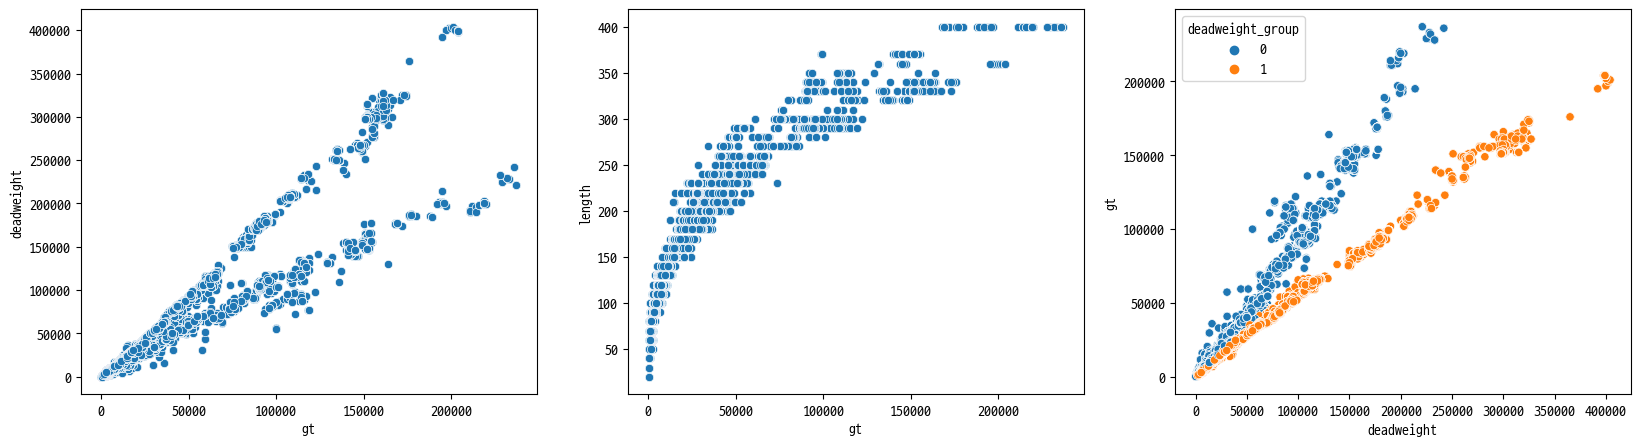

In [16]:
fig, axes = plt.subplots(1, 3, dpi=100, figsize=(20, 5))

cluster_index = np.abs(train['deadweight'] - 2*train['gt']) < np.abs(train['deadweight'] - train['gt'])
train['deadweight_group'] = 0
train.loc[cluster_index, 'deadweight_group'] = 1

cluster_index = np.abs(test['deadweight'] - 2*test['gt']) < np.abs(test['deadweight'] - test['gt'])
test['deadweight_group'] = 0
test.loc[cluster_index, 'deadweight_group'] = 1
test.loc[~cluster_index, 'deadweight_group'] = 0

sns.scatterplot(train, x='gt', y='deadweight', ax=axes[0])
sns.scatterplot(train, x='gt', y='length', ax=axes[1])
sns.scatterplot(data=train, x='deadweight', y='gt', hue='deadweight_group'); 

# Column Manipulation

In [17]:
for col in train.columns[train.dtypes=='object']:
    if col != 'ata':
        value_count = len(train[col].value_counts())
        print(f'columns {col:18s} has {value_count:6d} kinds of values')

columns ari_co             has     25 kinds of values
columns ari_po             has    103 kinds of values
columns ship_type_category has      4 kinds of values
columns shipmanager        has   5933 kinds of values
columns flag               has    118 kinds of values


In [18]:
encoder = LabelEncoder()
train.ari_co = encoder.fit_transform(train.ari_co)
test.ari_co = encoder.transform(test.ari_co)

train.ari_po = encoder.fit_transform(train.ari_po)
test.ari_po = encoder.transform(test.ari_po)

train.ship_type_category = encoder.fit_transform(train.ship_type_category)
test.ship_type_category = encoder.transform(test.ship_type_category)

In [19]:
train = train.drop(columns=['ata', 'shipmanager', 'flag', 'deadweight', 'length'])
test = test.drop(columns=['ata', 'shipmanager', 'flag', 'deadweight', 'length'])

In [20]:
train.head()

,ari_co,ari_po,ship_type_category,dist,breadth,built,depth,draught,gt,u_wind,v_wind,air_temperature,bn,ata_lt,port_size,ci_hour,month,wind_speed,deadweight_group
0,0,0,0,32.590869,40.0,28,20.0,20.0,86100,-0.363571,-1.574429,16.995714,4.061694,21,0.000113,161.218056,9,1.615862,1
1,0,0,0,35.575496,30.0,20,20.0,10.0,29400,-0.363571,-1.574429,16.995714,4.061694,11,0.000113,95.767500,9,1.615862,1
2,0,0,0,40.909139,40.0,13,20.0,10.0,48200,-0.363571,-1.574429,16.995714,4.061694,11,0.000113,35.445556,9,1.615862,1
3,0,0,0,45.939559,40.0,11,20.0,10.0,58600,-0.363571,-1.574429,16.995714,4.061694,11,0.000113,95.507222,9,1.615862,1
4,0,0,0,15.606497,30.0,11,20.0,10.0,44300,-0.363571,-1.574429,16.995714,4.061694,11,0.000113,99.873056,9,1.615862,1


# Save

In [21]:
print(train.shape[1] == test.shape[1] + 1)

True


In [22]:
train.to_csv('data/train_preprocessed.csv', encoding='UTF-8', index=False)
test.to_csv('data/test_preprocessed.csv', encoding='UTF-8', index=False)